Requirement

Chinese car company Geely Auto wants to enter the US market by establishing their manufacturing plant in the US to compete with American and European competitors in US market. Geely Auto has signed a contract with an automotive consulting company to find out the variables that impact on car prices. Specifically, they want to learn the characteristics of a car that will affect
affect the pricing of automobiles in the US market, because it is possible that the tastes of American consumers may
different from consumers in China.

As a data analyst, the above data is provided by the market survey department. You perform the analysis and build a car price forecasting model based on the collected attributes. Accordingly, managers can devise business strategies, vehicle designs, .. to meet the market segment they want to target.

In [5]:
#FINAL_ASSIGNMENT

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df = pd.read_csv("Case_study_CarPrice_Assignment.csv")

#Sửa lỗi dữ liệu
df[['brand','carname']] = df['CarName'].str.split(' ',n=1,expand=True)
df = df.replace({'maxda':'mazda','Nissan':'nissan','porcshce':'porsche','vokswagen':'volkswagen','toyouta':'toyota','vw':'volkswagen','porche':'porsche'})
colcar = df['carname'].str.replace(' ','')
df['carname'] = colcar.values
df = df.drop(['CarName'], axis=1)
print(df.info())
#Mã hóa dữ liệu
#label_Encoder
print(df['brand'].unique())
df[['brand','carbody', 'drivewheel','enginetype','fuelsystem']] = df[['brand','carbody', 'drivewheel','enginetype','fuelsystem']].apply(LabelEncoder().fit_transform)
#ordinal_encoder
df['symboling'] = df['symboling'].apply(str)
a = list(df['symboling'].unique())
a.sort(reverse=True)
safety_ranking = a
enc = OrdinalEncoder(categories = [safety_ranking])
df['symboling'] = enc.fit_transform(df[['symboling']])
#one_hot_encoding
df = pd.get_dummies(df, columns=['fueltype','aspiration','doornumber','enginelocation'],drop_first=True)
#convert remaining text to numbers
df = df.replace({'four':4,'six':6,'five':5,'three':3,'twelve':12,'two':2,'eight':8})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

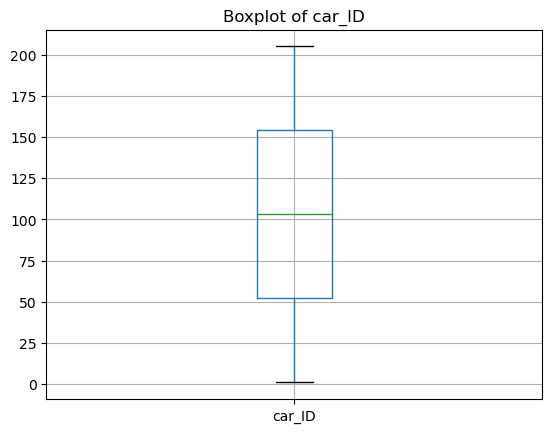

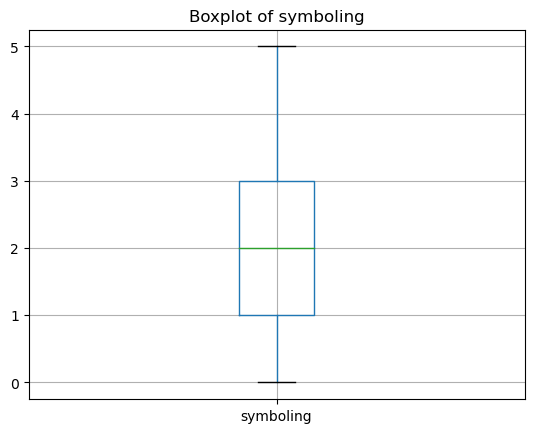

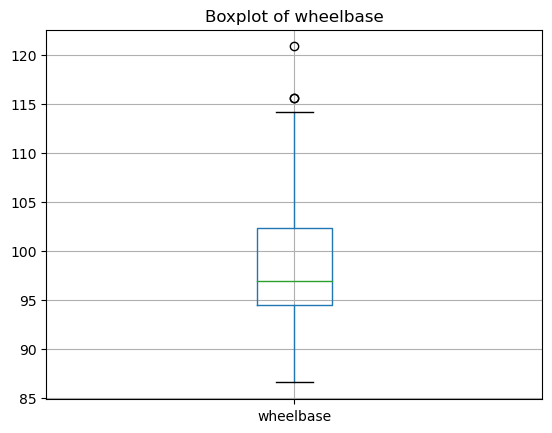

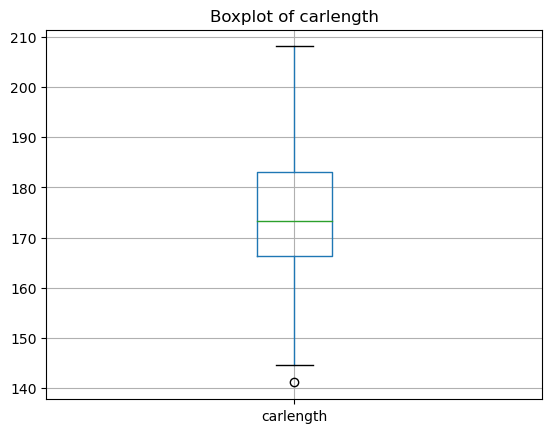

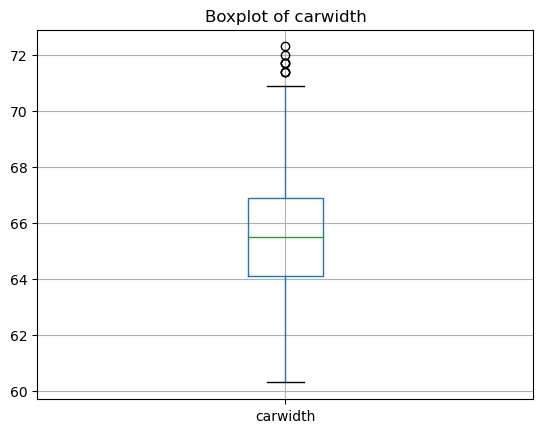

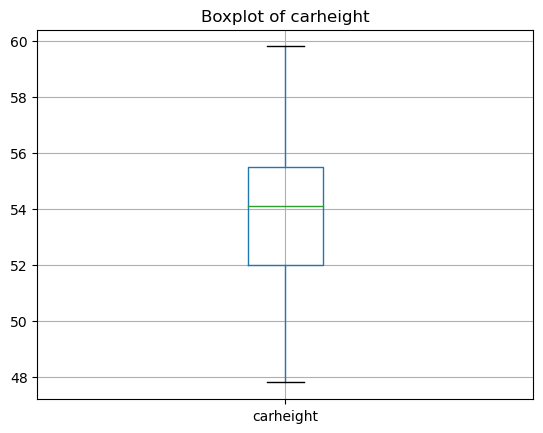

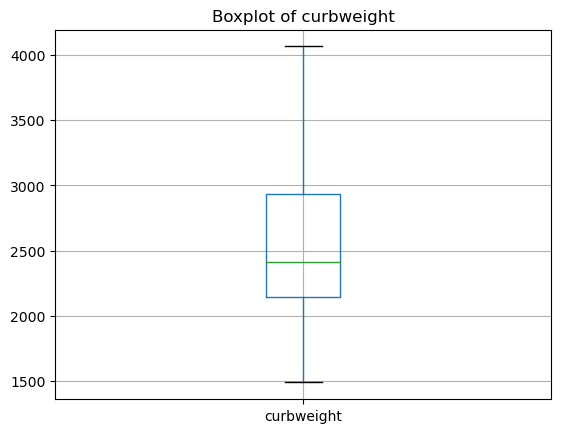

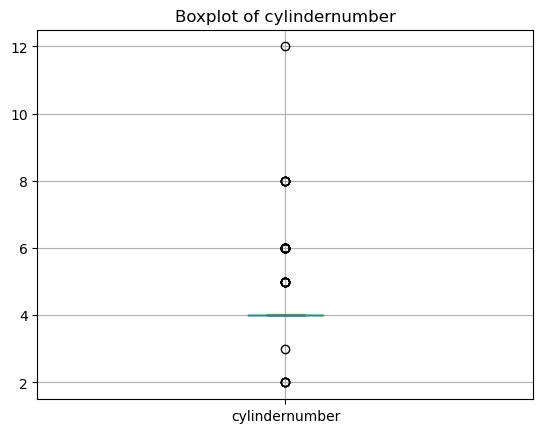

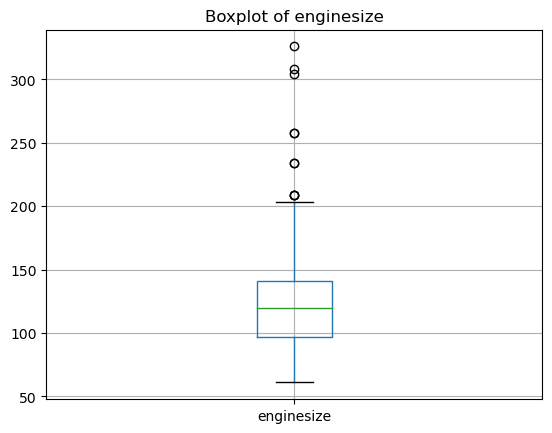

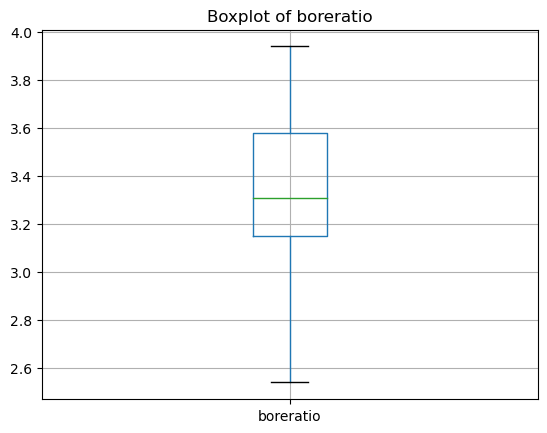

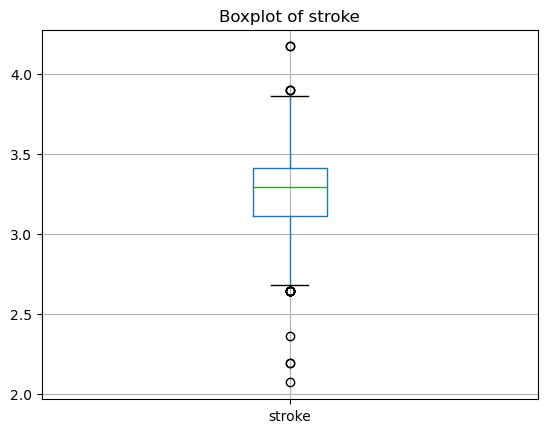

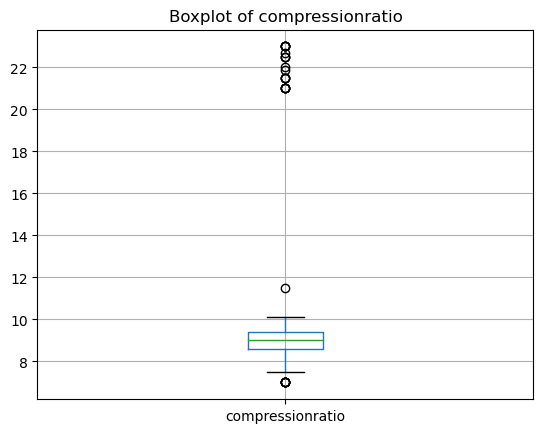

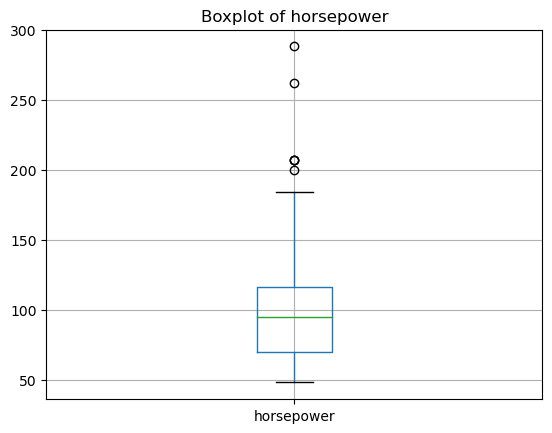

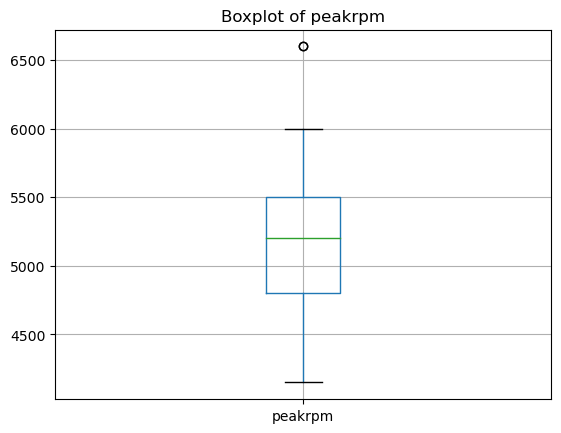

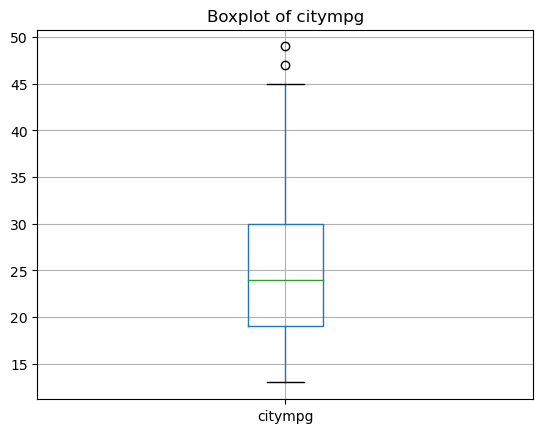

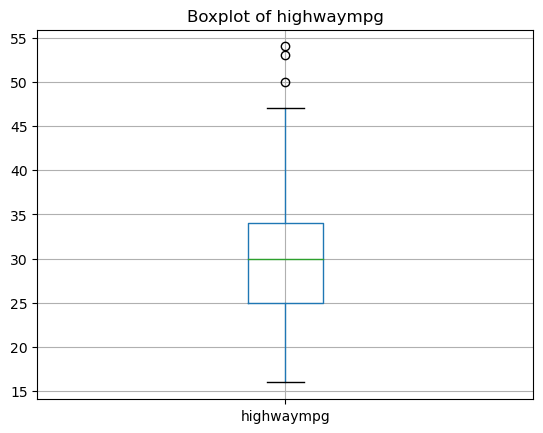

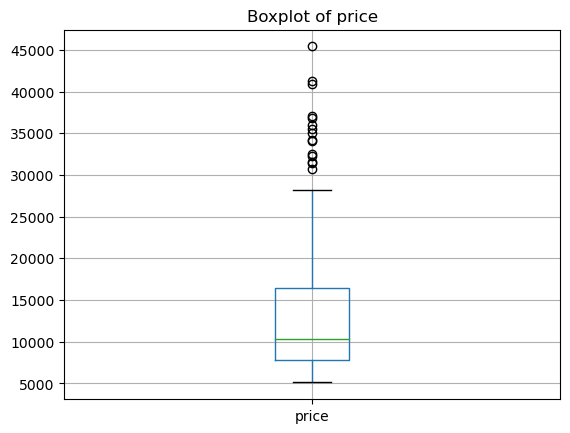

In [11]:
#Check for outliers
for col in df.loc[:, df.columns!='brand']: 
    if df[col].dtype in ['int64', 'float64']:
        # Create a boxplot of the current column
        df.boxplot(column=col)      
        # Set the title of the plot
        plt.title('Boxplot of ' + col)      
        # Display the plot
        plt.show()
#Summary: There is so many outliers in each sample variable that dropping them could result in lack of data.
#Suggestion: Keeping the outliers for further steps.

<AxesSubplot:>

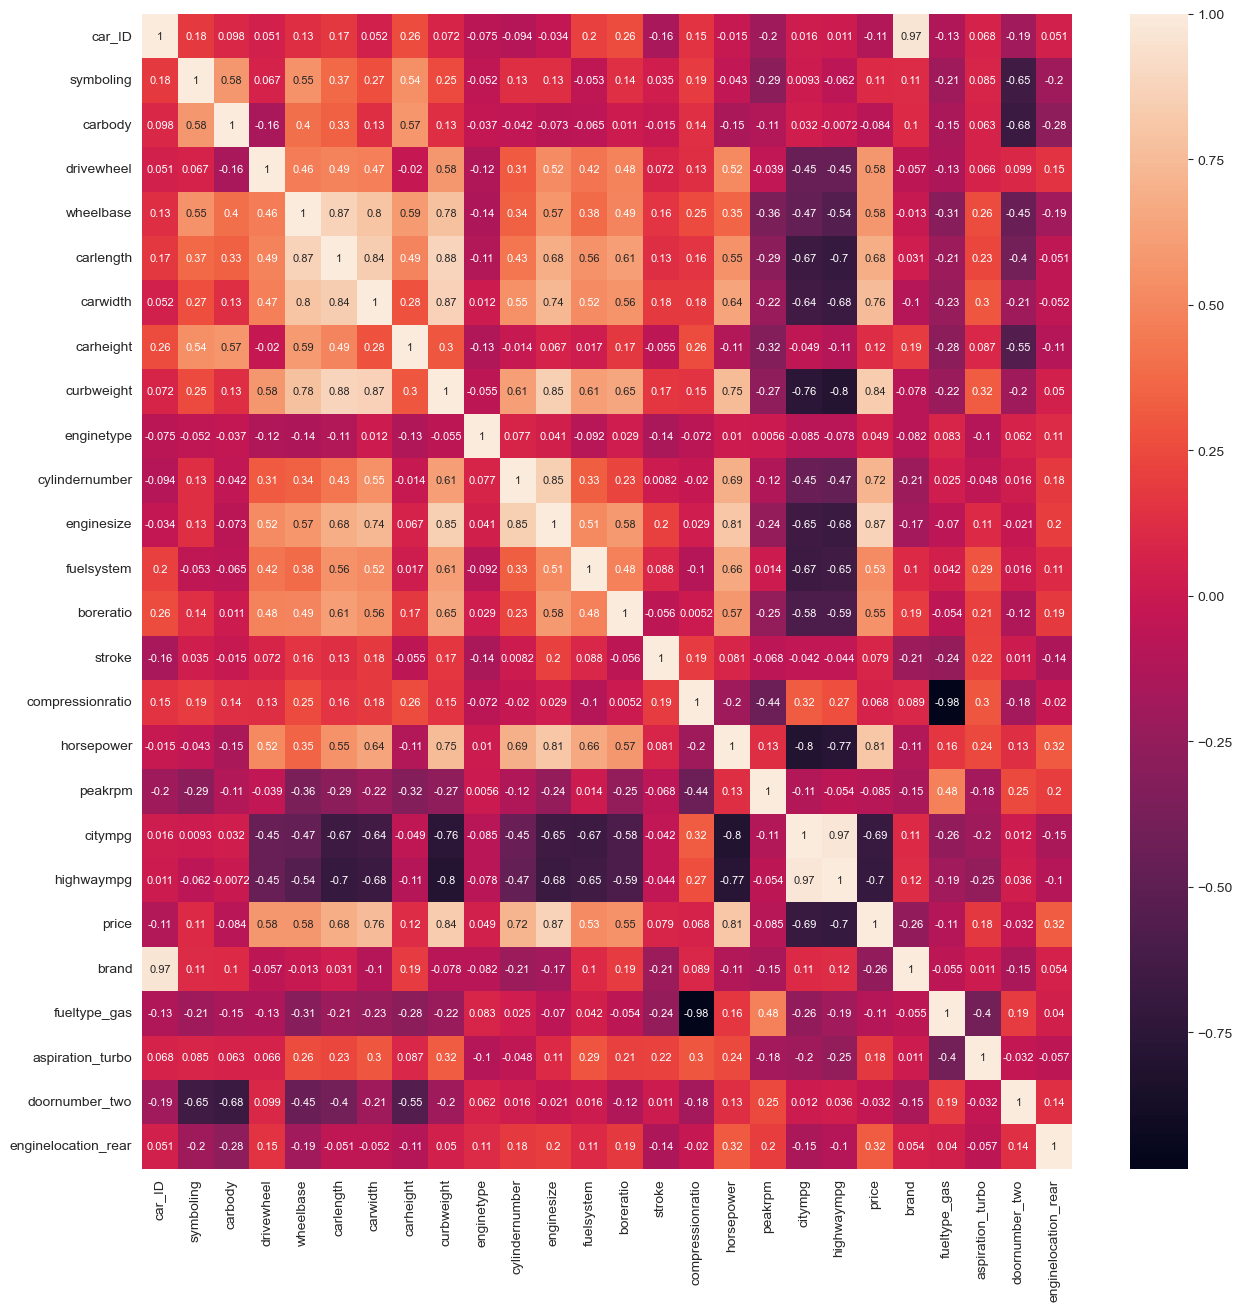

In [59]:
#heatmap between variables
df2 = df.corr(method ='pearson')
plt.figure(figsize = (15,15))
sns.heatmap(df2, annot=True,annot_kws={'fontsize':8})

In [60]:
#Kiểm định tương quan định lượng
#Pearson correlation and P-value
df.drop('carname', inplace=True, axis=1)
for col in df.columns:
    x = df[col]
    y = df['price']
    r, pvalue = pearsonr(x, y)
    print(col,'r=%.3f, pvalue=%.3f' % (r, pvalue))

car_ID r=-0.109, pvalue=0.119
symboling r=0.106, pvalue=0.129
carbody r=-0.084, pvalue=0.231
drivewheel r=0.578, pvalue=0.000
wheelbase r=0.578, pvalue=0.000
carlength r=0.683, pvalue=0.000
carwidth r=0.759, pvalue=0.000
carheight r=0.119, pvalue=0.088
curbweight r=0.835, pvalue=0.000
enginetype r=0.049, pvalue=0.484
cylindernumber r=0.718, pvalue=0.000
enginesize r=0.874, pvalue=0.000
fuelsystem r=0.527, pvalue=0.000
boreratio r=0.553, pvalue=0.000
stroke r=0.079, pvalue=0.258
compressionratio r=0.068, pvalue=0.333
horsepower r=0.808, pvalue=0.000
peakrpm r=-0.085, pvalue=0.224
citympg r=-0.686, pvalue=0.000
highwaympg r=-0.698, pvalue=0.000
price r=1.000, pvalue=0.000
brand r=-0.262, pvalue=0.000
fueltype_gas r=-0.106, pvalue=0.132
aspiration_turbo r=0.178, pvalue=0.011
doornumber_two r=-0.032, pvalue=0.650
enginelocation_rear r=0.325, pvalue=0.000


Conclusion:
Tạo 2 mô hình hồi quy rồi so sánh giữa 2 model 
1. 2nd model: chọn tất cả các thuộc tính ngoài carID vào mô hình hồi quy
2. 1st model: chọn những thuộc tính có p_value < 0.05 vào mô hình hồi quy

Eng:
Create 2 regression models and compare between the 2 models
1. 2nd model: select all attributes other than carID into the regression model
2. 1st model: select attributes with p_value < 0.05 into the regression model

In [61]:
#xóa thuộc tính car_ID
#delete car_ID from dataframe because cars IDs are used for query purposes
del df['car_ID']

In [63]:
#chuẩn hóa dữ liệu cho dataset của 1st model
#normalize data for dataset of 1st model
df2 = df.drop(['symboling', 'carbody', 'carheight', 'enginetype', 'stroke', 'compressionratio', 'peakrpm', 'fueltype_gas', 'doornumber_two'], axis=1)
col_names = list(df2.columns)
sc = StandardScaler()
d = sc.fit_transform(df2)
d = pd.DataFrame(d, columns = col_names)
d.head()

,drivewheel,wheelbase,carlength,carwidth,curbweight,cylindernumber,enginesize,fuelsystem,boreratio,horsepower,citympg,highwaympg,price,brand,aspiration_turbo,enginelocation_rear
0,1.213330,-1.690772,-0.426521,-0.844782,-0.014566,-0.352887,0.074449,0.869568,0.519071,0.174483,-0.646553,-0.546059,0.027391,-1.945332,-0.469295,-0.121867
1,1.213330,-1.690772,-0.426521,-0.844782,-0.014566,-0.352887,0.074449,0.869568,0.519071,0.174483,-0.646553,-0.546059,0.404461,-1.945332,-0.469295,-0.121867
2,1.213330,-0.708596,-0.231513,-0.190566,0.514882,1.502032,0.604046,0.869568,-2.404880,1.264536,-0.953012,-0.691627,0.404461,-1.945332,-0.469295,-0.121867
3,-0.589081,0.173698,0.207256,0.136542,-0.420797,-0.352887,-0.431076,0.869568,-0.517266,-0.053668,-0.186865,-0.109354,0.084485,-1.785879,-0.469295,-0.121867
4,-2.391492,0.107110,0.207256,0.230001,0.516807,0.574572,0.218885,0.869568,-0.517266,0.275883,-1.106241,-1.273900,0.523668,-1.785879,-0.469295,-0.121867


In [64]:
#chuẩn hóa dữ liệu cho dataset của 2nd model
#normalize data for dataset of 2nd model
columnsdf = list(df.columns)
sc2 = StandardScaler()
d1 = sc2.fit_transform(df)
d1 = pd.DataFrame(d1, columns = columnsdf)
d1.head()

,symboling,carbody,drivewheel,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,...,horsepower,peakrpm,citympg,highwaympg,price,brand,fueltype_gas,aspiration_turbo,doornumber_two,enginelocation_rear
0,-1.610242,-3.050975,1.213330,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,-2.865105,-0.352887,...,0.174483,-0.262960,-0.646553,-0.546059,0.027391,-1.945332,0.328798,-0.469295,1.130388,-0.121867
1,-1.610242,-3.050975,1.213330,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,-2.865105,-0.352887,...,0.174483,-0.262960,-0.646553,-0.546059,0.404461,-1.945332,0.328798,-0.469295,1.130388,-0.121867
2,-0.184326,-0.717207,1.213330,-0.708596,-0.231513,-0.190566,-0.543527,0.514882,1.886890,1.502032,...,1.264536,-0.262960,-0.953012,-0.691627,0.404461,-1.945332,0.328798,-0.469295,1.130388,-0.121867
3,-0.897284,0.449677,-0.589081,0.173698,0.207256,0.136542,0.235942,-0.420797,-0.013908,-0.352887,...,-0.053668,0.787855,-0.186865,-0.109354,0.084485,-1.785879,0.328798,-0.469295,-0.884652,-0.121867
4,-0.897284,0.449677,-2.391492,0.107110,0.207256,0.230001,0.235942,0.516807,-0.013908,0.574572,...,0.275883,0.787855,-1.106241,-1.273900,0.523668,-1.785879,0.328798,-0.469295,-0.884652,-0.121867


2nd model with training and testing data set.

In [66]:
#2nd model
y = d1['price']
X= d1.loc[:, d1.columns != "price"]
exog = sm.add_constant(X)
estimator = sm.OLS(y,exog).fit()
print(estimator.summary())
#Split the arrays into training and testing data sets
X_train, X_test,y_train, y_test= train_test_split(X,y,test_size=0.3,random_state=0)
#Create a regressor object
LR= LinearRegression()
#Fit training set to the regressor
LR.fit(X_train,y_train)
#Make predictions with the regressor
y_prediction = LR.predict(X_test)
print('Mean_sqrd_error is==',mean_squared_error(y_test,y_prediction))
print('Root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_prediction)))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     68.08
Date:                Fri, 10 Feb 2023   Prob (F-statistic):           2.55e-77
Time:                        19:07:00   Log-Likelihood:                -54.080
No. Observations:                 205   AIC:                             158.2
Df Residuals:                     180   BIC:                             241.2
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.596e-16    

1st model with training and testing data set.

In [67]:
#1st model
y = d['price']
X= d.loc[:, d.columns != "price"]
exog = sm.add_constant(X)
estimator = sm.OLS(y,exog).fit()
print(estimator.summary())
#Split the arrays into training and testing data sets
X_train, X_test,y_train, y_test= train_test_split(X,y,test_size=0.3,random_state=0)
#Create a regressor object
LR= LinearRegression()
#Fit training set to the regressor
LR.fit(X_train,y_train)
#Make predictions with the regressor
y_prediction = LR.predict(X_test)
print('Mean_sqrd_error is==',mean_squared_error(y_test,y_prediction))
print('Root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_prediction)))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     96.46
Date:                Fri, 10 Feb 2023   Prob (F-statistic):           5.78e-80
Time:                        19:07:13   Log-Likelihood:                -69.670
No. Observations:                 205   AIC:                             171.3
Df Residuals:                     189   BIC:                             224.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.596e-16    

In [68]:
#Cải thiện 1st model bằng cách bỏ những biến(x) có p_value > 0.05, chúng ta có 3rd model.
#improving 1st model by removing independent variables(x) with p_value > 0.05, we have 3rd model.
y = d['price']
X=d.loc[:, ~d.columns.isin(['wheelbase','carlength','cylindernumber','fuelsystem','boreratio','citympg','highwaympg','aspiration_turbo','price'])]
exog = sm.add_constant(X)
estimator = sm.OLS(y,exog).fit()
print(estimator.summary())
#Split the arrays into training and testing data sets
X_train, X_test,y_train, y_test= train_test_split(X,y,test_size=0.3,random_state=0)
#Create a regressor object
LR= LinearRegression()
#Fit training set to the regressor
LR.fit(X_train,y_train)
#Make predictions with the regressor
y_prediction = LR.predict(X_test)
print('Mean_sqrd_error is==',mean_squared_error(y_test,y_prediction))
print('Root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_prediction)))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     210.1
Date:                Fri, 10 Feb 2023   Prob (F-statistic):           9.22e-88
Time:                        19:07:23   Log-Likelihood:                -71.925
No. Observations:                 205   AIC:                             159.8
Df Residuals:                     197   BIC:                             186.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.596e-16    

Kết luận: trong 3 mô hình hồi quy vừa tạo mô hình 3rd model là tốt nhất vì:
1. Sự khác biệt giữa R-squared và Adj-Rsquared của 3rd model là thấp nhât trong cả 3 mô hình.
2. Mean_sqrd_error ở 3rd model là bé nhất trong cả 3 mô hình.
3. Các biến độc lập (thuộc tính xe) đều có p_value < 0.05

Eng:
Conclusion: Of all the 3 regression models just created, the 3rd model is the best for few reasons.Firstly, the difference between R-squared and Adj-Rsquared of the 3rd model is the lowest of all 3 models. Secondly, Mean_sqrd_error in 3rd model is the smallest of all 3 models.Finally, All he independent variables (vehicle attributes) in the 3rd model have p_value < 0.05. From 3rd model we can see Americans value some key vehicle attributes such as drive wheel, car width, curb weight, engine size, horse power and engine location when they buy cars because those variables have positive correlation with car price. In addition, brand recognition and position is significant factor for car price in US market. 